In [28]:
import tensorflow as tf, json, os
from tensorflow.keras import layers, models

# -----------------------------
# 1. Konfigurasi
# -----------------------------
TRAIN_DIR = "data/known_faces/train"
VAL_DIR   = "data/known_faces/validation"
IMG_SIZE = (180,180)
BATCH_SIZE = 10
EPOCHS = 50

# -----------------------------
# 2. Load Dataset
# -----------------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Kelas terdeteksi:", class_names)

# -----------------------------
# 3. Augmentasi & Prefetch
# -----------------------------
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# augmentasi hanya untuk training
train_ds = train_ds.map(lambda x,y: (data_augmentation(x), y))

# prefetch untuk efisiensi
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# -----------------------------
# 4. Model CNN sederhana
# -----------------------------
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=IMG_SIZE+(3,)),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# -----------------------------
# 5. Training dengan validasi
# -----------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# -----------------------------
# 6. Simpan Model & Mapping
# -----------------------------
model.save("data/face_recognition_model.h5")
with open("data/class_indices.json","w") as f:
    json.dump({i: name for i, name in enumerate(class_names)}, f)

print("✅ Model dan class_indices berhasil disimpan.")

Found 36 files belonging to 17 classes.
Found 17 files belonging to 17 classes.
Kelas terdeteksi: ['Afif', 'Aghni', 'Ariel', 'Aulia', 'Aurel', 'Dimas', 'Eliza', 'Endika', 'Evinda', 'Farhan', 'Hanif', 'Igo', 'Kriza', 'Nuril', 'Ovi', 'Riko', 'Sabrina']
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 773ms/step - accuracy: 0.0556 - loss: 3.7437 - val_accuracy: 0.0588 - val_loss: 2.8336
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 687ms/step - accuracy: 0.0833 - loss: 2.8449 - val_accuracy: 0.0588 - val_loss: 2.8222
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step - accuracy: 0.0556 - loss: 2.8320 - val_accuracy: 0.0588 - val_loss: 2.8147
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step - accuracy: 0.1389 - loss: 2.8003 - val_accuracy: 0.0588 - val_loss: 2.7830
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step - accuracy: 0.1111 - loss: 2.7915 - val_accuracy: 0.0588 - val_loss: 2.7463
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step - accuracy: 0.1389 - loss: 2.7481 - val_accuracy: 0.0588 - val_loss: 

✅ Model dan class_indices berhasil disimpan.


In [30]:
import tensorflow as tf, json, os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

# -----------------------------
# 1. Load Model & Mapping
# -----------------------------
model = tf.keras.models.load_model("data/face_recognition_model.h5")

with open("data/class_indices.json") as f:
    class_indices = json.load(f)

# Balik mapping agar index -> nama kelas
idx_to_class = {int(k): v for k, v in class_indices.items()}

# -----------------------------
# 2. Fungsi Prediksi Satu Gambar
# -----------------------------
def predict_image(img_path, target_size=(180,180)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    preds = model.predict(img_array, verbose=0)[0]
    cls_id = int(np.argmax(preds))
    prob = float(np.max(preds))
    return idx_to_class[cls_id], prob

# -----------------------------
# 3. Loop Semua Gambar di Folder
# -----------------------------
DATA_DIR = "data/known_faces/validation"
results = []

for class_name in os.listdir(DATA_DIR):
    class_path = os.path.join(DATA_DIR, class_name)
    if not os.path.isdir(class_path):
        continue
    for fname in os.listdir(class_path):
        if not fname.lower().endswith((".jpg",".jpeg",".png")):
            continue
        fpath = os.path.join(class_path, fname)
        pred_label, prob = predict_image(fpath)
        results.append((fname, class_name, pred_label, prob))
        print(f"File: {fname} | Asli: {class_name} | Prediksi: {pred_label} | Prob: {prob:.2f}")

# -----------------------------
# 4. Hitung Akurasi Keseluruhan
# -----------------------------
correct = sum(1 for _, true, pred, _ in results if true == pred)
total = len(results)
print(f"\n✅ Akurasi keseluruhan: {correct}/{total} = {correct/total:.2%}")

File: IMG_20251027_135735.jpg | Asli: Afif | Prediksi: Aurel | Prob: 0.53
File: IMG-20251026-WA0035.jpg | Asli: Aghni | Prediksi: Aurel | Prob: 0.54
File: IMG_20251027_135653.jpg | Asli: Ariel | Prediksi: Aurel | Prob: 0.54
File: IMG-20251027-WA0081.jpg | Asli: Aulia | Prediksi: Aurel | Prob: 0.53
File: IMG-20251027-WA0089.jpg | Asli: Aurel | Prediksi: Aurel | Prob: 0.54
File: IMG_20251027_135259.jpg | Asli: Dimas | Prediksi: Aurel | Prob: 0.54
File: IMG-20251027-WA0085.jpg | Asli: Eliza | Prediksi: Aurel | Prob: 0.54
File: IMG_20251027_135801.jpg | Asli: Endika | Prediksi: Aurel | Prob: 0.54
File: IMG-20251027-WA0019.jpg | Asli: Evinda | Prediksi: Aurel | Prob: 0.54
File: IMG_20251027_135220.jpg | Asli: Farhan | Prediksi: Aurel | Prob: 0.54
File: IMG_20251027_135130.jpg | Asli: Hanif | Prediksi: Aurel | Prob: 0.53
File: IMG-20251026-WA0084.jpg | Asli: Igo | Prediksi: Aurel | Prob: 0.54
File: IMG_20251027_135846.jpg | Asli: Kriza | Prediksi: Aurel | Prob: 0.54
File: IMG-20251027-WA0088

Found 36 images belonging to 17 classes.
Found 17 images belonging to 17 classes.


d:\PROJECT\dinda\venv\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
d:\PROJECT\dinda\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 286ms/step - accuracy: 0.1000 - loss: 3.0827 - val_accuracy: 0.1000 - val_loss: 3.0793
Epoch 2/50
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.3977 - loss: 2.4650

d:\PROJECT\dinda\venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.4375 - loss: 2.4803 - val_accuracy: 0.1000 - val_loss: 3.1181
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.3000 - loss: 2.4176 - val_accuracy: 0.1000 - val_loss: 3.0306
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.3750 - loss: 2.0958 - val_accuracy: 0.1000 - val_loss: 2.9181
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - accuracy: 0.6000 - loss: 2.1170 - val_accuracy: 0.0000e+00 - val_loss: 3.1323
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.6875 - loss: 1.8028 - val_accuracy: 0.0000e+00 - val_loss: 3.1649
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - accuracy: 0.8500 - loss: 1.6403 - val_accuracy: 0.1000 - val_loss: 2.9517
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.7500 - loss: 1.5906 - val_accuracy: 0.1000 - val_loss: 2.7505
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - accuracy: 0.9000 - loss: 1.4263 - val_accuracy: 0.100

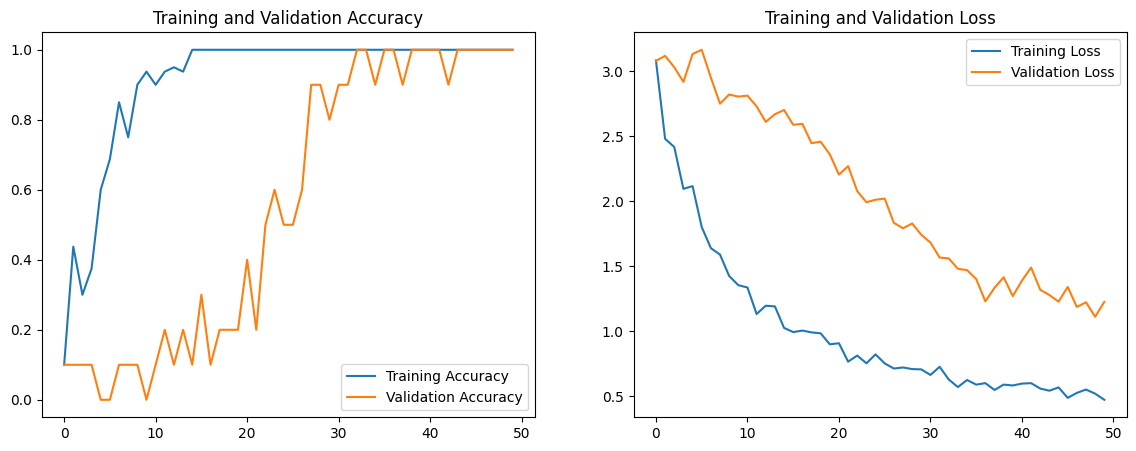

FileNotFoundError: [Errno 2] No such file or directory: 'data/known_faces\\train\\data/known_faces/afif1.jpg'

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import img_to_array, load_img

# -----------------------------
# 1. Konfigurasi dataset
# -----------------------------
base_dir = "data/known_faces"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
# test_dir = os.path.join(base_dir, 'test')

folders = os.listdir(train_dir)   # nama kelas

# -----------------------------
# 2. Data generator
# -----------------------------
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 50),   # sesuai referensi
    batch_size=1
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(100, 50),
    batch_size=1
)

# -----------------------------
# 3. Model CNN manual
# -----------------------------
img_input = layers.Input(shape=(100, 50, 3))

x = layers.Conv2D(16, (3,3), activation='relu')(img_input)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(32, (3,3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.BatchNormalization()(x)

x = layers.Flatten()(x)
x = layers.Dense(50, activation='sigmoid')(x)

output = layers.Dense(len(folders), activation='softmax')(x)

model = Model(img_input, output)

# -----------------------------
# 4. Compile
# -----------------------------
model.compile(
    loss='categorical_crossentropy',   # lebih tepat untuk multi-class
    optimizer=SGD(learning_rate=0.0001, momentum=0.9, decay=1e-6),
    metrics=['accuracy']
)

# -----------------------------
# 5. Training
# -----------------------------
history = model.fit(
    train_generator,
    steps_per_epoch=20,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=10,
    verbose=1
)

# -----------------------------
# 6. Plot hasil training
# -----------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [33]:
from keras.preprocessing.image import load_img, img_to_array

# Loop semua gambar di folder train
results = []
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    for fname in os.listdir(class_path):
        if not fname.lower().endswith((".jpg",".jpeg",".png")):
            continue
        fpath = os.path.join(class_path, fname)

        # Preprocess gambar
        img = load_img(fpath, color_mode='rgb', target_size=(100,50))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0) / 255.0

        # Prediksi
        preds = model.predict(x, verbose=0)
        index_preds = np.argmax(preds)
        prob = float(np.max(preds))
        pred_label = folders[index_preds]

        # Simpan hasil
        results.append((fname, class_name, pred_label, prob))
        print(f"File: {fname} | Asli: {class_name} | Prediksi: {pred_label} | Prob: {prob:.2f}")

# Hitung akurasi keseluruhan
correct = sum(1 for _, true, pred, _ in results if true == pred)
total = len(results)
print(f"\n✅ Akurasi keseluruhan: {correct}/{total} = {correct/total:.2%}")


File: afif1.jpg | Asli: Afif | Prediksi: Afif | Prob: 0.57
File: IMG_20251027_135730.jpg | Asli: Afif | Prediksi: Afif | Prob: 0.58
File: IMG-20251026-WA0026.jpg | Asli: Aghni | Prediksi: Aghni | Prob: 0.51
File: IMG-20251026-WA0027.jpg | Asli: Aghni | Prediksi: Aghni | Prob: 0.48
File: IMG-20251026-WA0028.jpg | Asli: Aghni | Prediksi: Aghni | Prob: 0.51
File: IMG_20251027_135545.jpg | Asli: Ariel | Prediksi: Ariel | Prob: 0.51
File: IMG_20251027_135603.jpg | Asli: Ariel | Prediksi: Ariel | Prob: 0.51
File: IMG-20251027-WA0079.jpg | Asli: Aulia | Prediksi: Aulia | Prob: 0.59
File: IMG-20251027-WA0080.jpg | Asli: Aulia | Prediksi: Aulia | Prob: 0.66
File: IMG-20251027-WA0082.jpg | Asli: Aurel | Prediksi: Aurel | Prob: 0.72
File: IMG-20251027-WA0087.jpg | Asli: Aurel | Prediksi: Aurel | Prob: 0.68
File: IMG_20251027_135241.jpg | Asli: Dimas | Prediksi: Dimas | Prob: 0.43
File: IMG_20251027_135254.jpg | Asli: Dimas | Prediksi: Dimas | Prob: 0.57
File: IMG-20251027-WA0065.jpg | Asli: Eliza